In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

from tqdm.notebook import tqdm

import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_error

from IMV_LSTM import IMVFullLSTM

import os
from IPython.utils import io

import time

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning);


Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
pl.seed_everything(8);

Global seed set to 8


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize']=12,8

In [4]:
df_og = pd.read_csv('Bike_Sharing_Daily.csv')

data1=df_og.iloc[:-99,:]
data2=df_og.iloc[-99:,:]

data1.drop(columns = 'datetime',inplace = True)
data2.drop(columns = 'datetime',inplace = True)

target = 'total_count'
cols = list(data1.columns)

C:\Users\eduma\AppData\Local\Temp\ipykernel_9764\455810338.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.drop(columns = 'datetime',inplace = True)
C:\Users\eduma\AppData\Local\Temp\ipykernel_9764\455810338.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(columns = 'datetime',inplace = True)


In [5]:
train_size = data1.shape[0]
val_size = 99
depth = 15
batch_size = 15
prediction_horizon = 1

In [6]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [7]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [8]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [9]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [10]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [11]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [12]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [13]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [14]:
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((99, 15, 27), (99,))

In [15]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [16]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [17]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [18]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)

In [19]:
model = IMVFullLSTM(X_train.shape[2], 1, 64)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

  0%|          | 0/10001 [00:00<?, ?it/s]

Saving...
Iter:  0 train:  0.40651842455164844 val:  0.23277826223767206
Iter time:  46.09400000004098
mse:  3717578.8 mae:  1592.6676


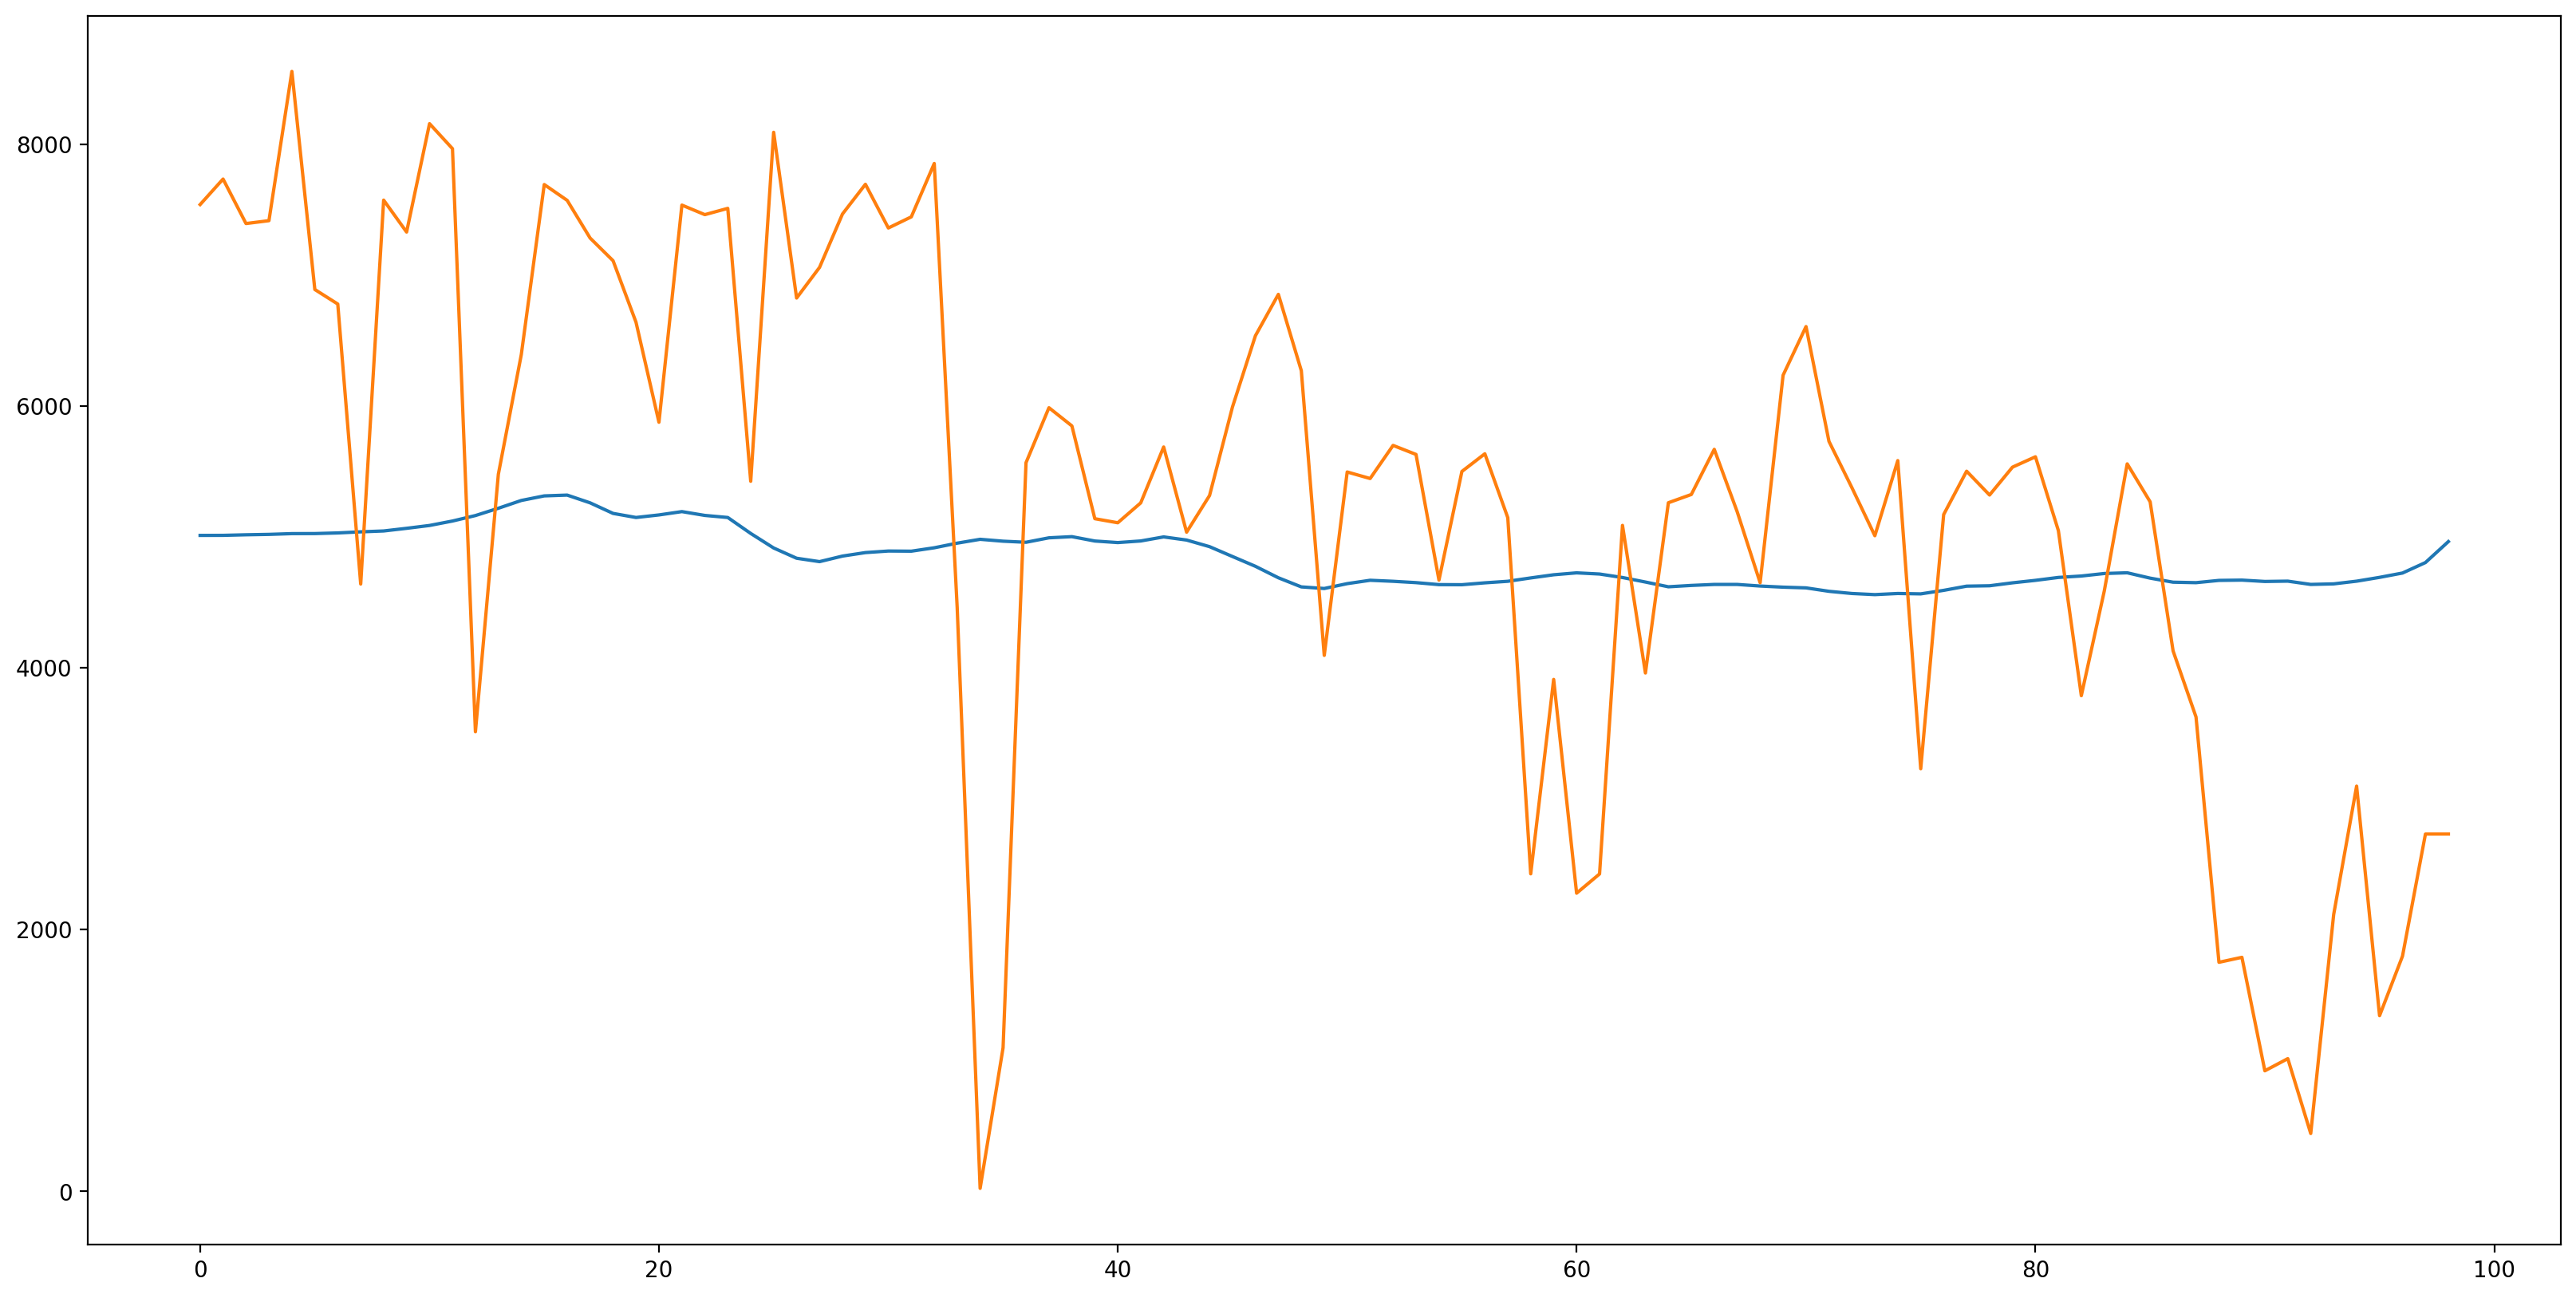

Saving...
Iter:  1 train:  0.14625068581549514 val:  0.21669871570760538
Iter time:  53.82800000003772
Iter:  2 train:  0.12747098594120926 val:  0.22025563580491672
Iter time:  56.06299999996554
Iter:  3 train:  0.12082264408395374 val:  0.22254726591024745
Iter time:  65.48399999999674
Iter:  4 train:  0.11936576158560419 val:  0.22051334712552495
Iter time:  62.98399999999674
Iter:  5 train:  0.11560449120725849 val:  0.2275888192869775
Iter time:  63.0
Saving...
Iter:  6 train:  0.11226228743581605 val:  0.21187252825049413
Iter time:  65.48500000004424
Iter:  7 train:  0.11407786606640155 val:  0.3394015289876417
Iter time:  70.21899999998277
Iter:  8 train:  0.11787005763400159 val:  0.23367666234636505
Iter time:  75.43699999997625
Iter:  9 train:  0.11274214810283102 val:  0.21228728690849077
Iter time:  78.96799999999348
Iter:  10 train:  0.11504981810659431 val:  0.28998319635931263
Iter time:  74.21900000004098
mse:  5769271.5 mae:  1734.9148


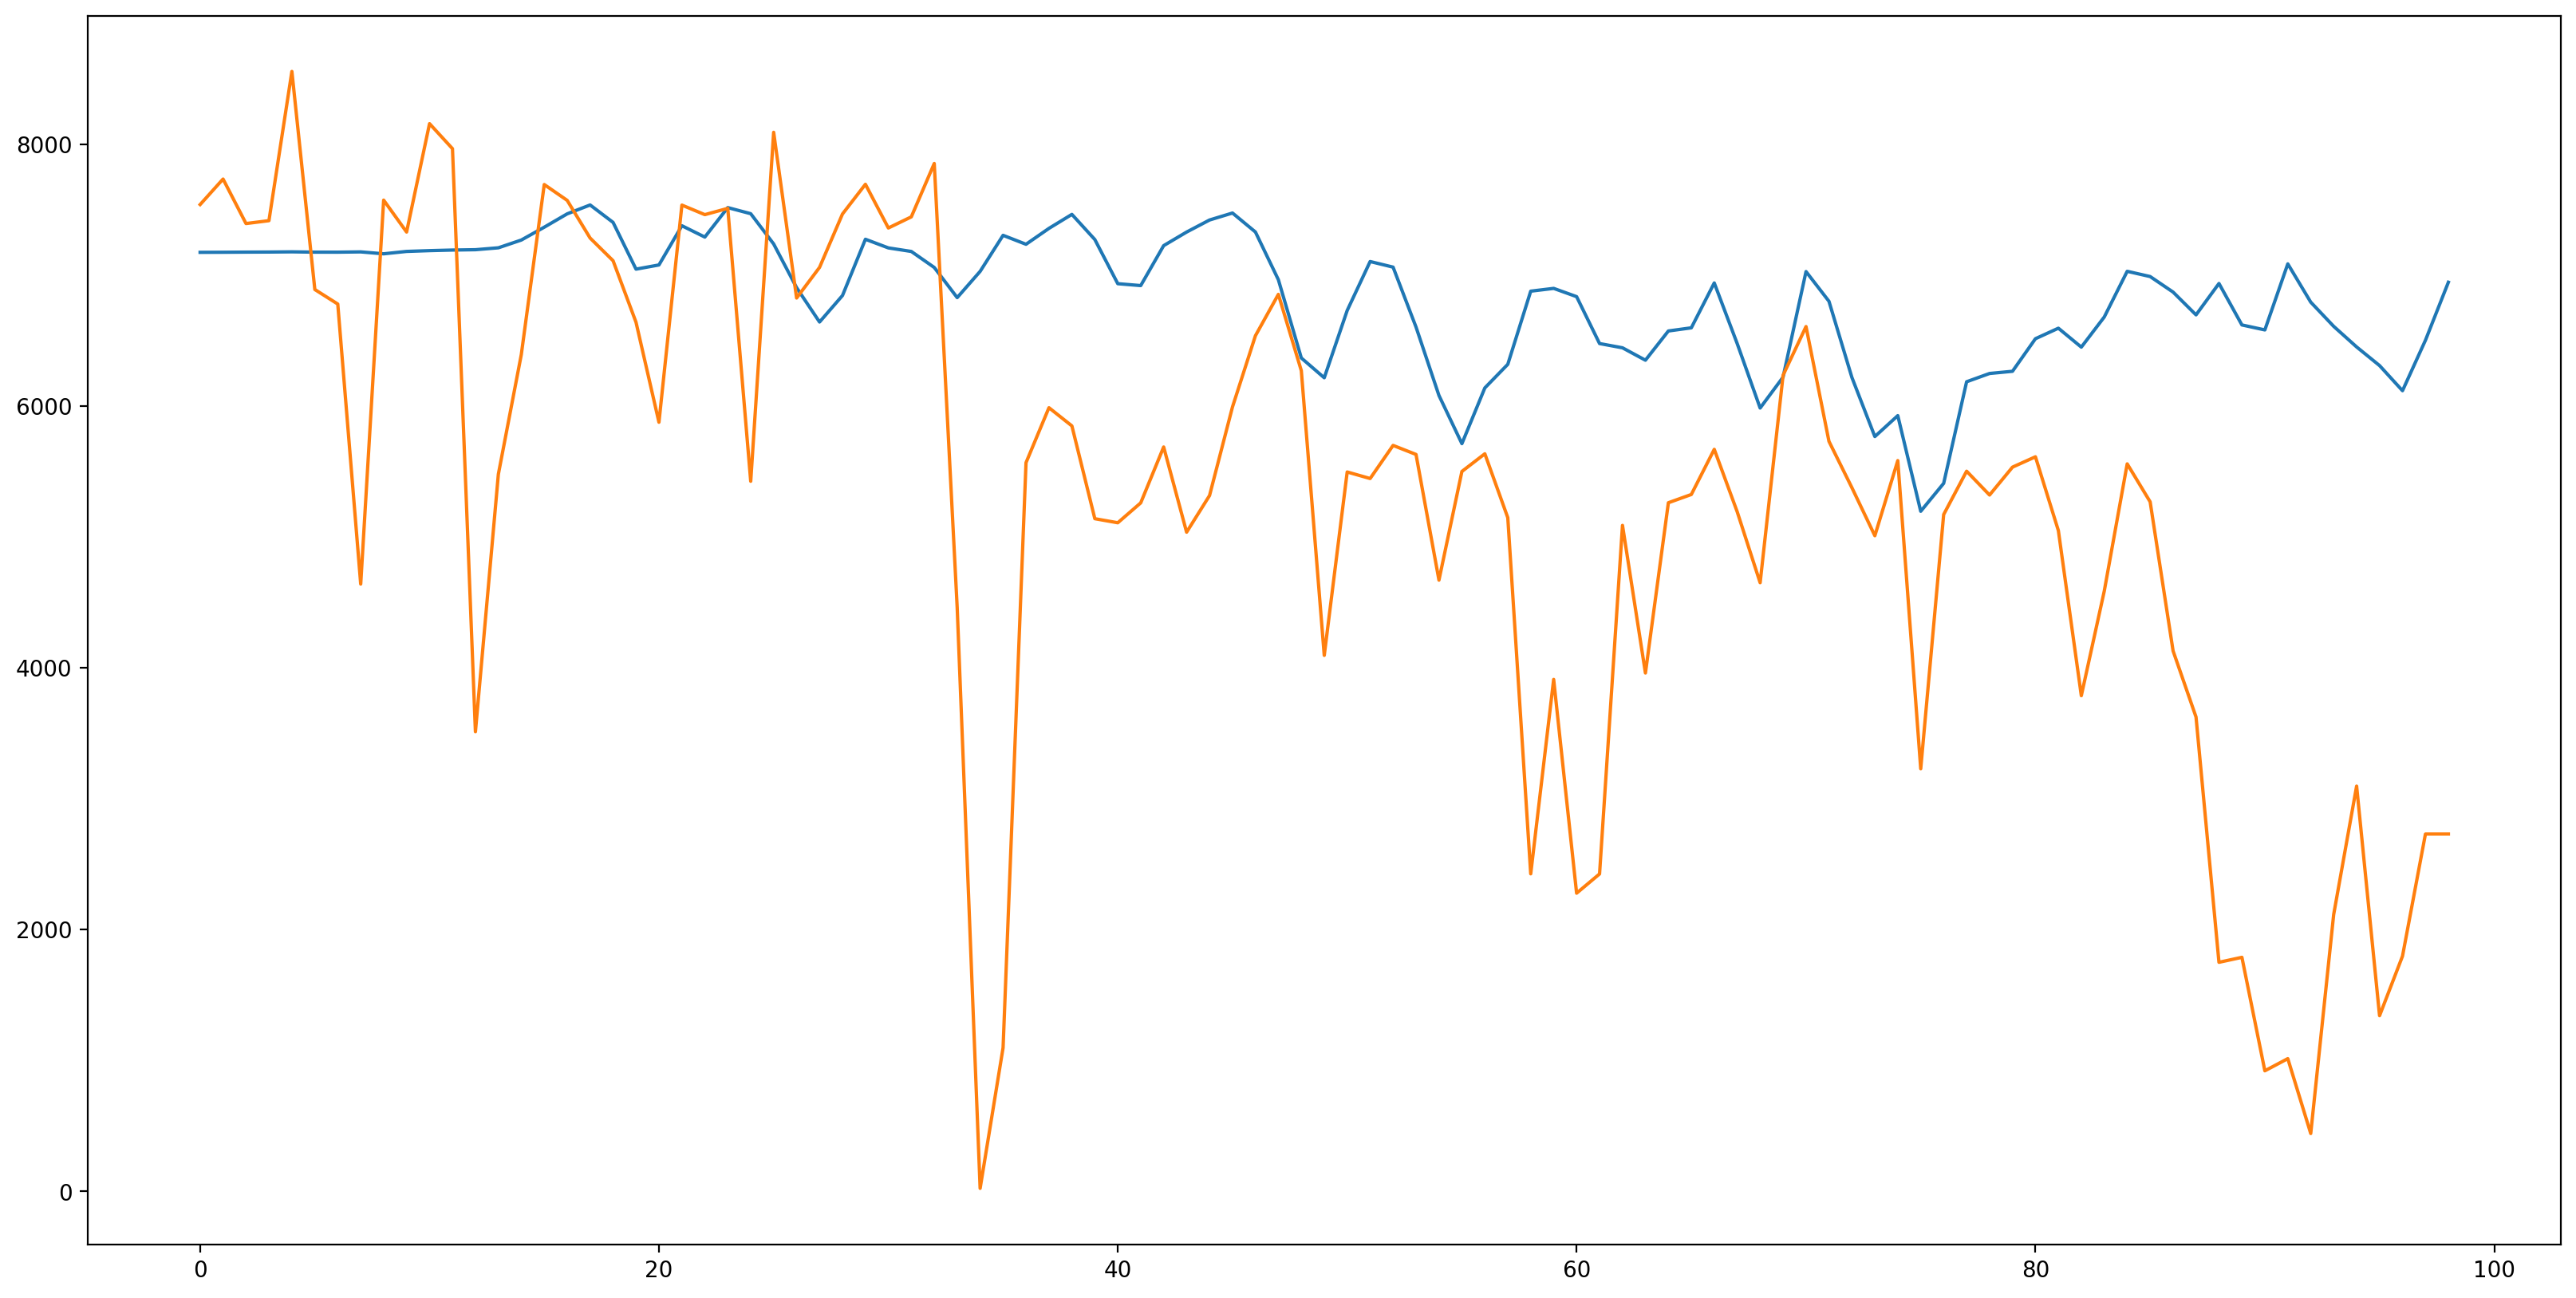

Iter:  11 train:  0.11873798490258762 val:  0.21298811938779605
Iter time:  81.57800000003772
Iter:  12 train:  0.11104107109942397 val:  0.23821397205618258
Iter time:  77.59399999998277
Iter:  13 train:  0.1091740665218134 val:  0.21267547133801323
Iter time:  76.10899999999674
Iter:  14 train:  0.11113915042360409 val:  0.2160794206400779
Iter time:  73.57799999997951
Iter:  15 train:  0.10761490658272176 val:  0.22755517287368118
Iter time:  75.84299999999348
Iter:  16 train:  0.10615304838723591 val:  0.21731664256066868
Iter time:  81.17200000002049
Iter:  17 train:  0.10508667377827796 val:  0.21845975770208934
Iter time:  85.73499999998603
Iter:  18 train:  0.10775455240900098 val:  0.23285962329616308
Iter time:  96.71799999999348
Iter:  19 train:  0.10475358637893811 val:  0.24014994847512475
Iter time:  100.06300000002375
Iter:  20 train:  0.10667869725955205 val:  0.22277079783684864
Iter time:  84.25
mse:  3404802.0 mae:  1331.9634


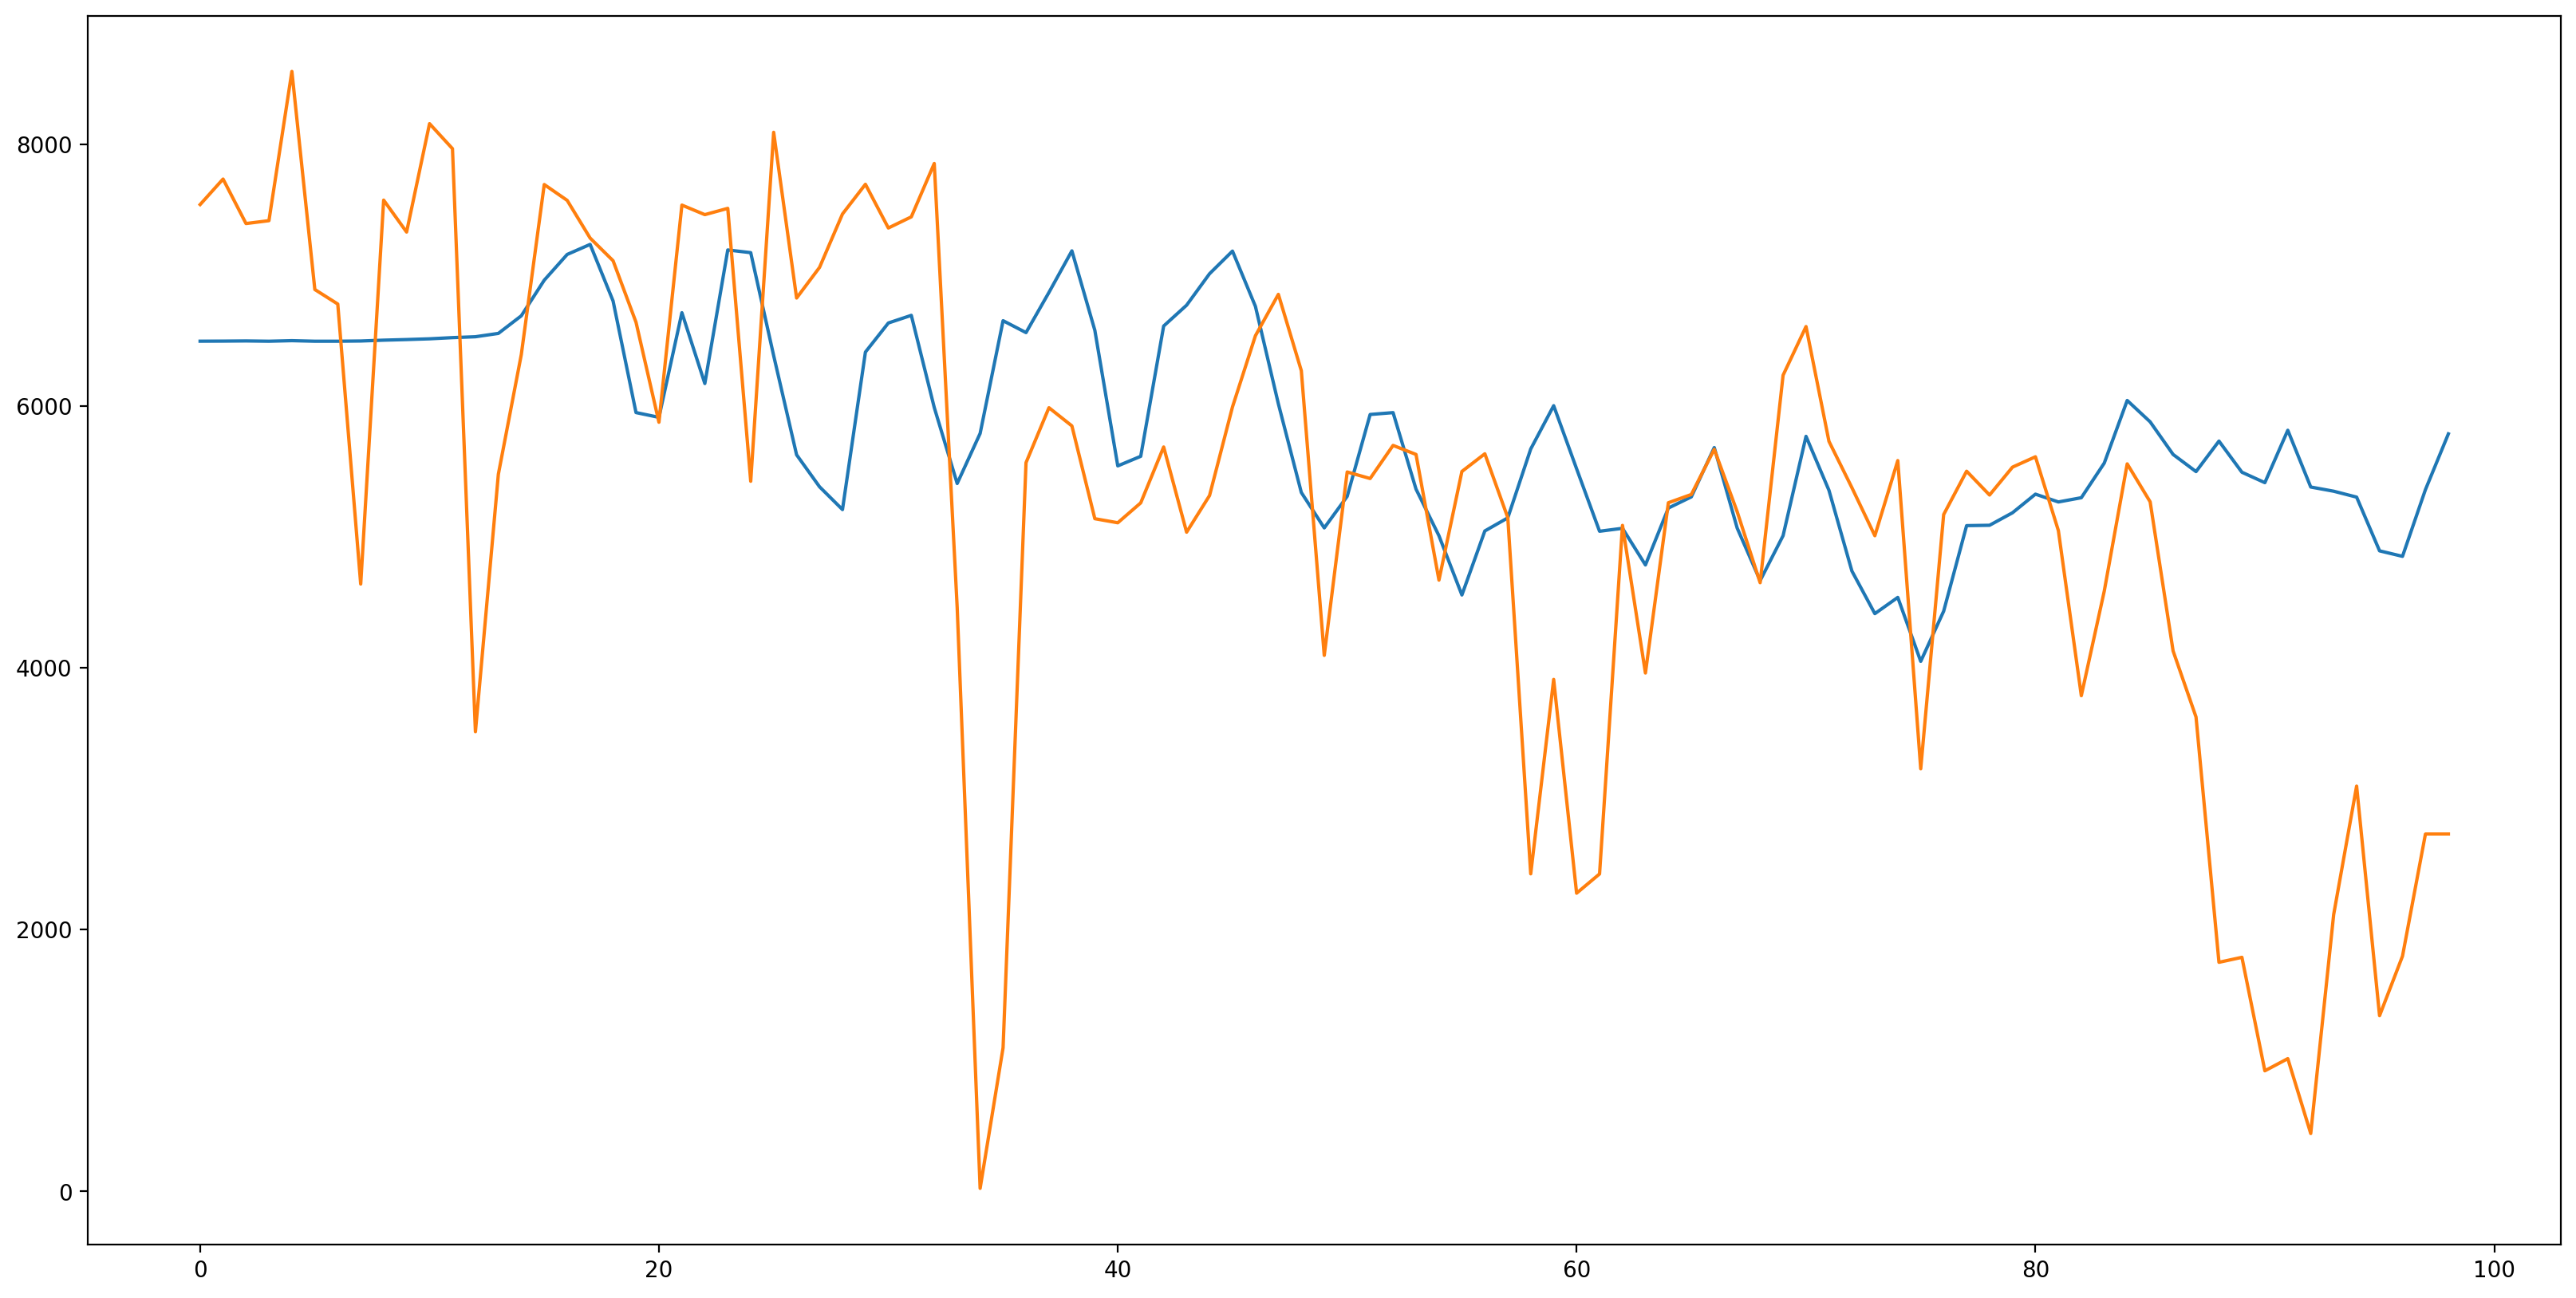

Iter:  21 train:  0.1019203972323932 val:  0.2446639579755872
Iter time:  87.90599999995902
Iter:  22 train:  0.10150225887537191 val:  0.2209081485186612
Iter time:  84.61000000004424
Iter:  23 train:  0.09944171213528968 val:  0.28156743740453527
Iter time:  85.45299999997951
Iter:  24 train:  0.09847366353953743 val:  0.22917127214649902
Iter time:  86.90600000001723
Iter:  25 train:  0.10347581268202354 val:  0.23781397998890666
Iter time:  83.42199999996228
Iter:  26 train:  0.10046462099893623 val:  0.2513842361198672
Iter time:  84.48399999999674
Iter:  27 train:  0.09659041103298409 val:  0.25195505900018206
Iter time:  86.53200000000652
Iter:  28 train:  0.10139449679796232 val:  0.25918737297181965
Iter time:  84.875
Iter:  29 train:  0.09678305651564216 val:  0.2367864546326031
Iter time:  92.23399999999674
Iter:  30 train:  0.1031743590139232 val:  0.2253266858639096
Iter time:  102.84400000004098
mse:  3483377.5 mae:  1482.8


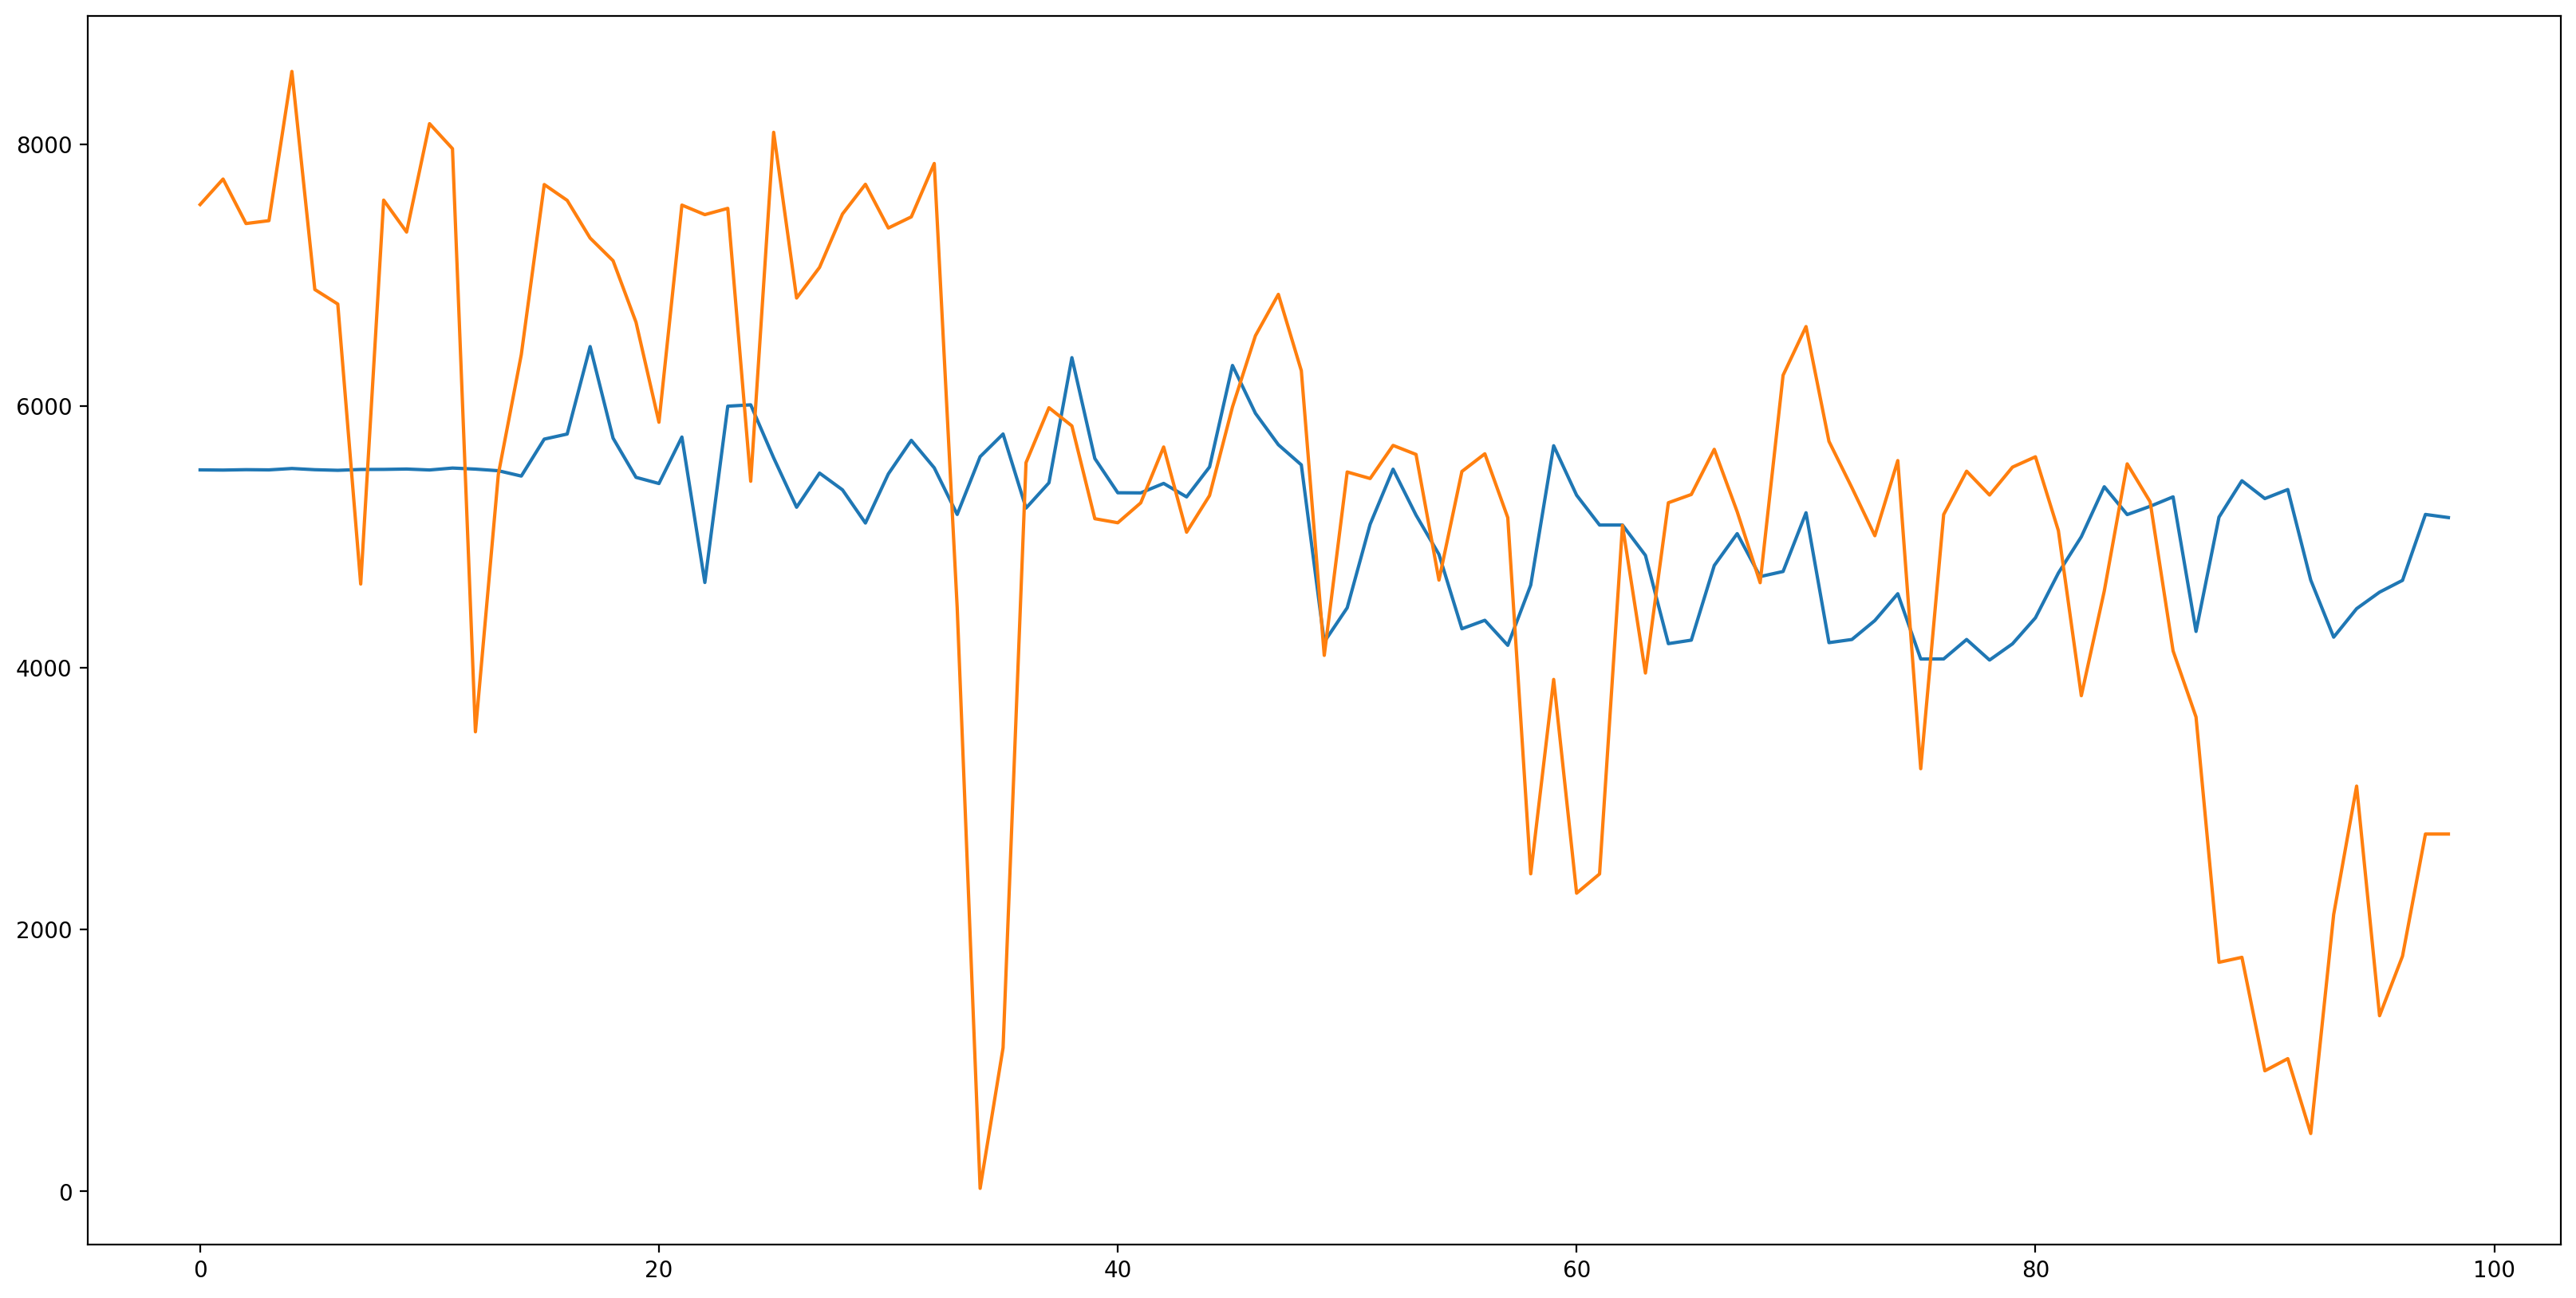

Iter:  31 train:  0.10243054043843537 val:  0.22651153024005166
Iter time:  102.93800000002375
Iter:  32 train:  0.10128254719183595 val:  0.23053500761569945
Iter time:  112.26600000000326
Iter:  33 train:  0.10069405410922508 val:  0.2352730793933159
Iter time:  121.98399999999674
Iter:  34 train:  0.09160863811775417 val:  0.22240012707327333
Iter time:  122.09399999998277
Iter:  35 train:  0.08749490169783032 val:  0.23868220062464296
Iter time:  118.21799999999348
mse:  3609926.8 mae:  1392.193


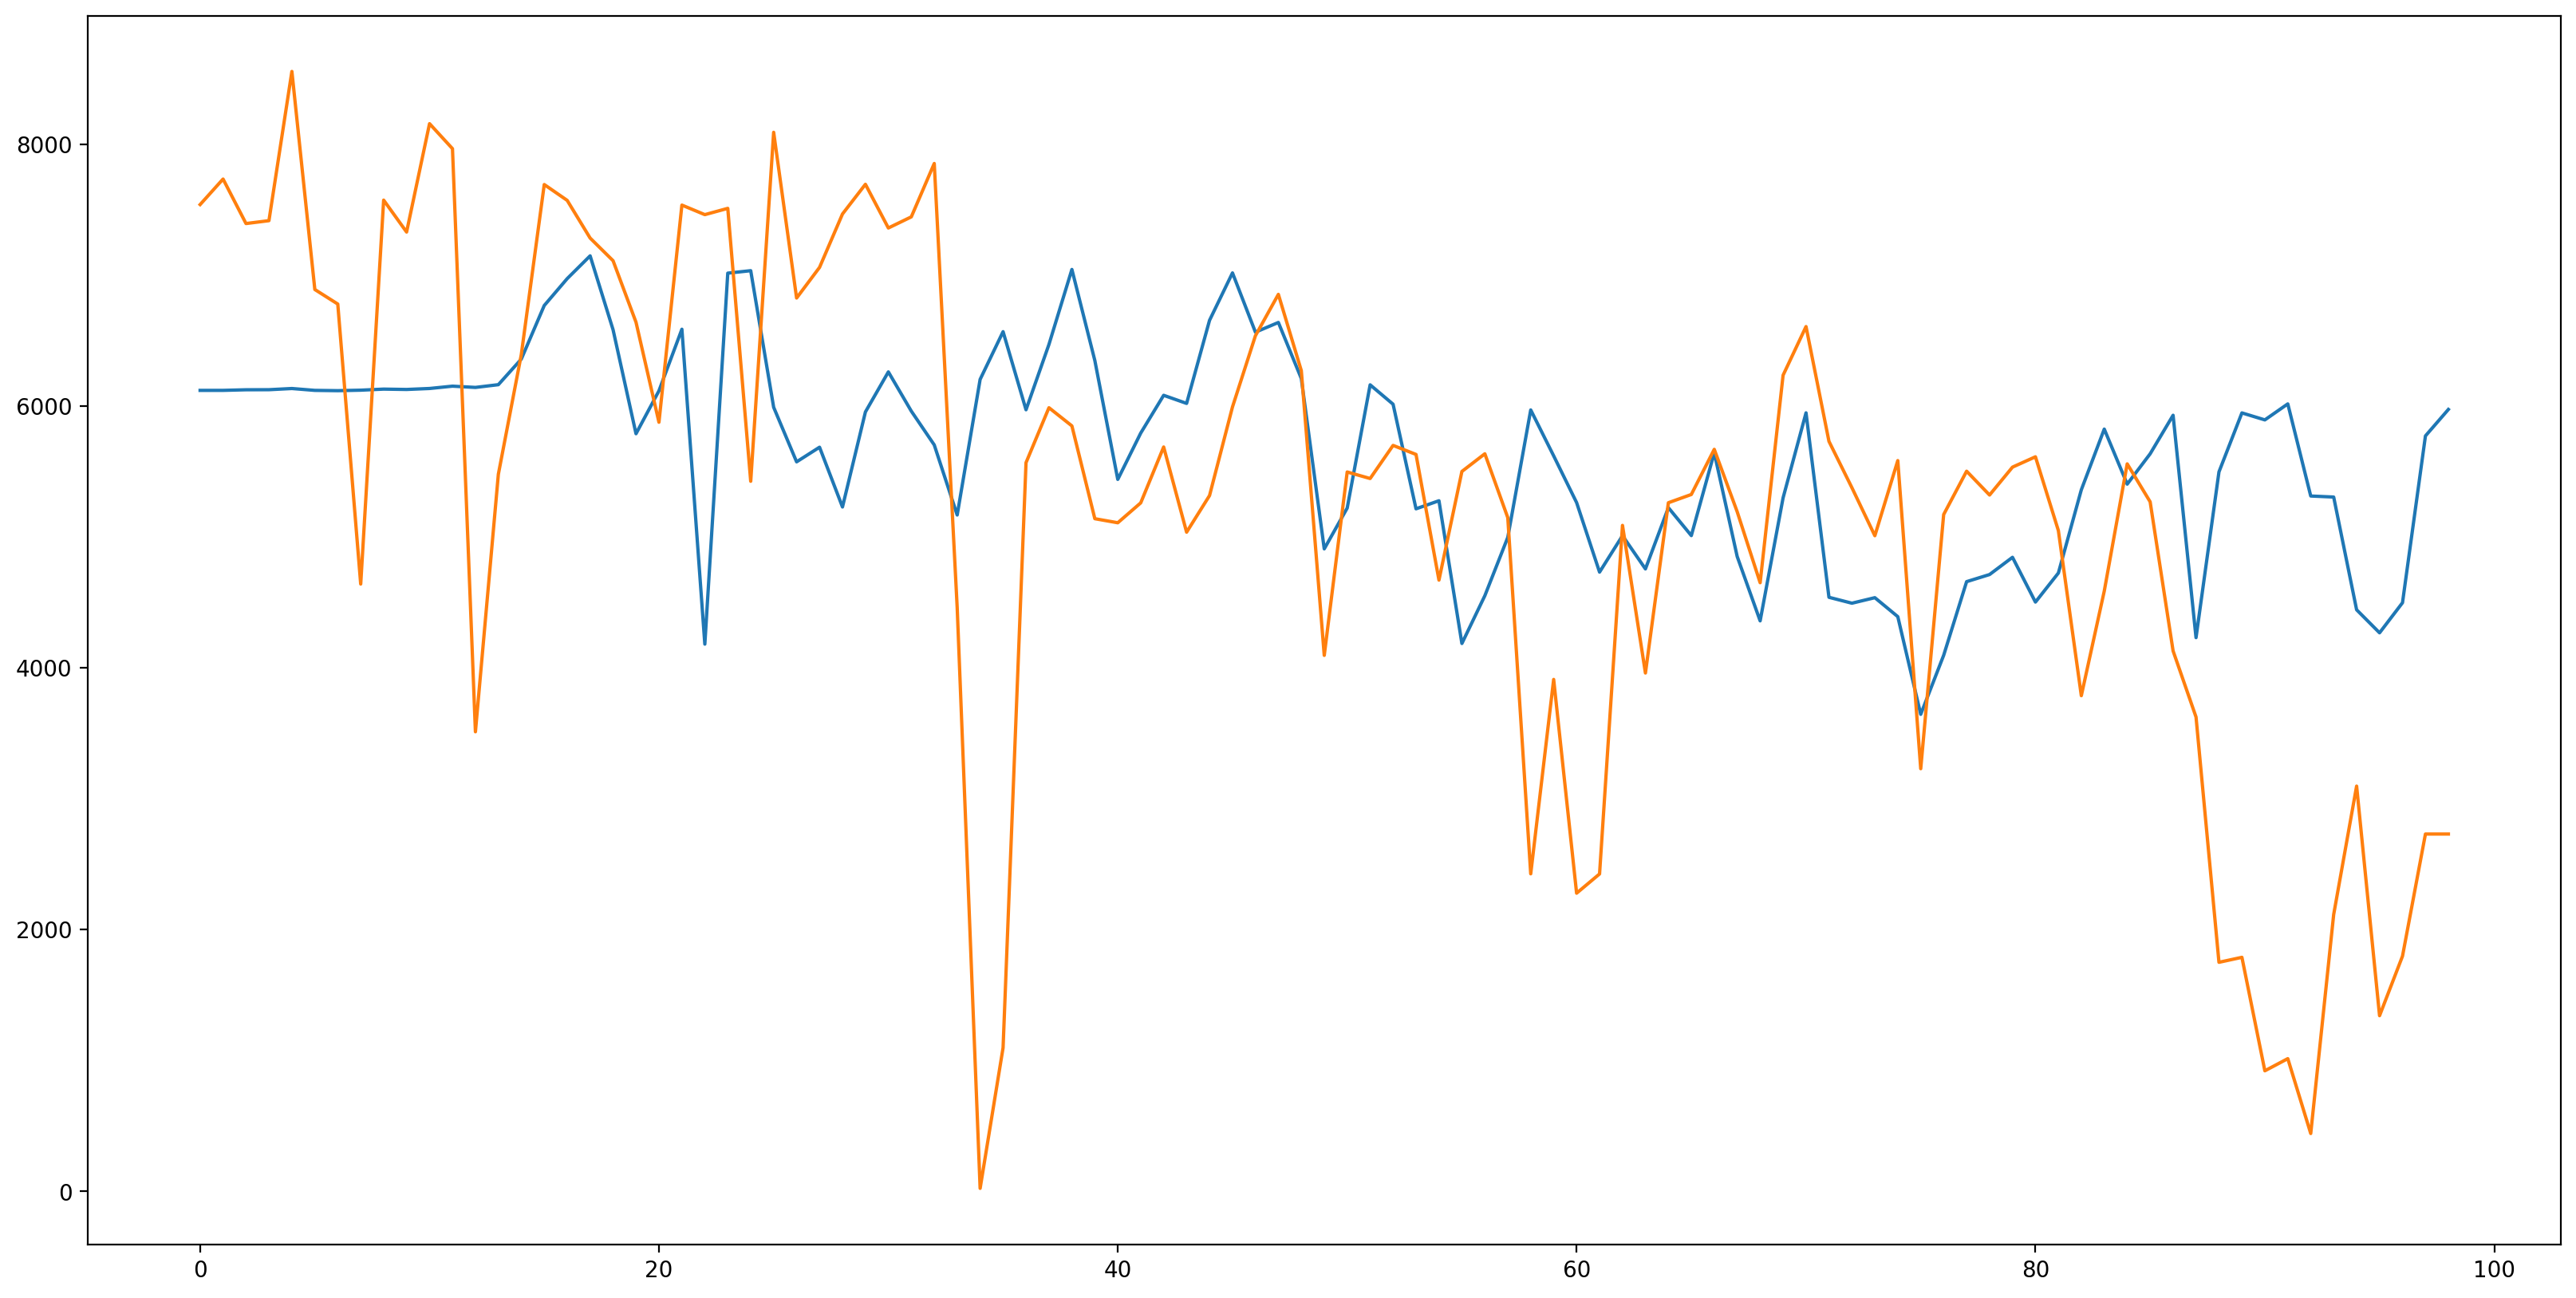

In [21]:
epochs = 10001
loss = nn.MSELoss()
patience = 30
min_val_loss = 9999
counter = 0
for i in tqdm(range(epochs)):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x
        batch_y = batch_y
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    #with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    
    for batch_x, batch_y in val_loader:
        batch_x = batch_x
        batch_y = batch_y
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    alphas = np.concatenate(alphas)
    betas = np.concatenate(betas)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_full_lstm.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [22]:
alphas.shape, betas.shape

((99, 15, 27, 1), (99, 27, 1))

In [23]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [24]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [25]:
alphas = alphas.transpose(1, 0)

(15, 27)


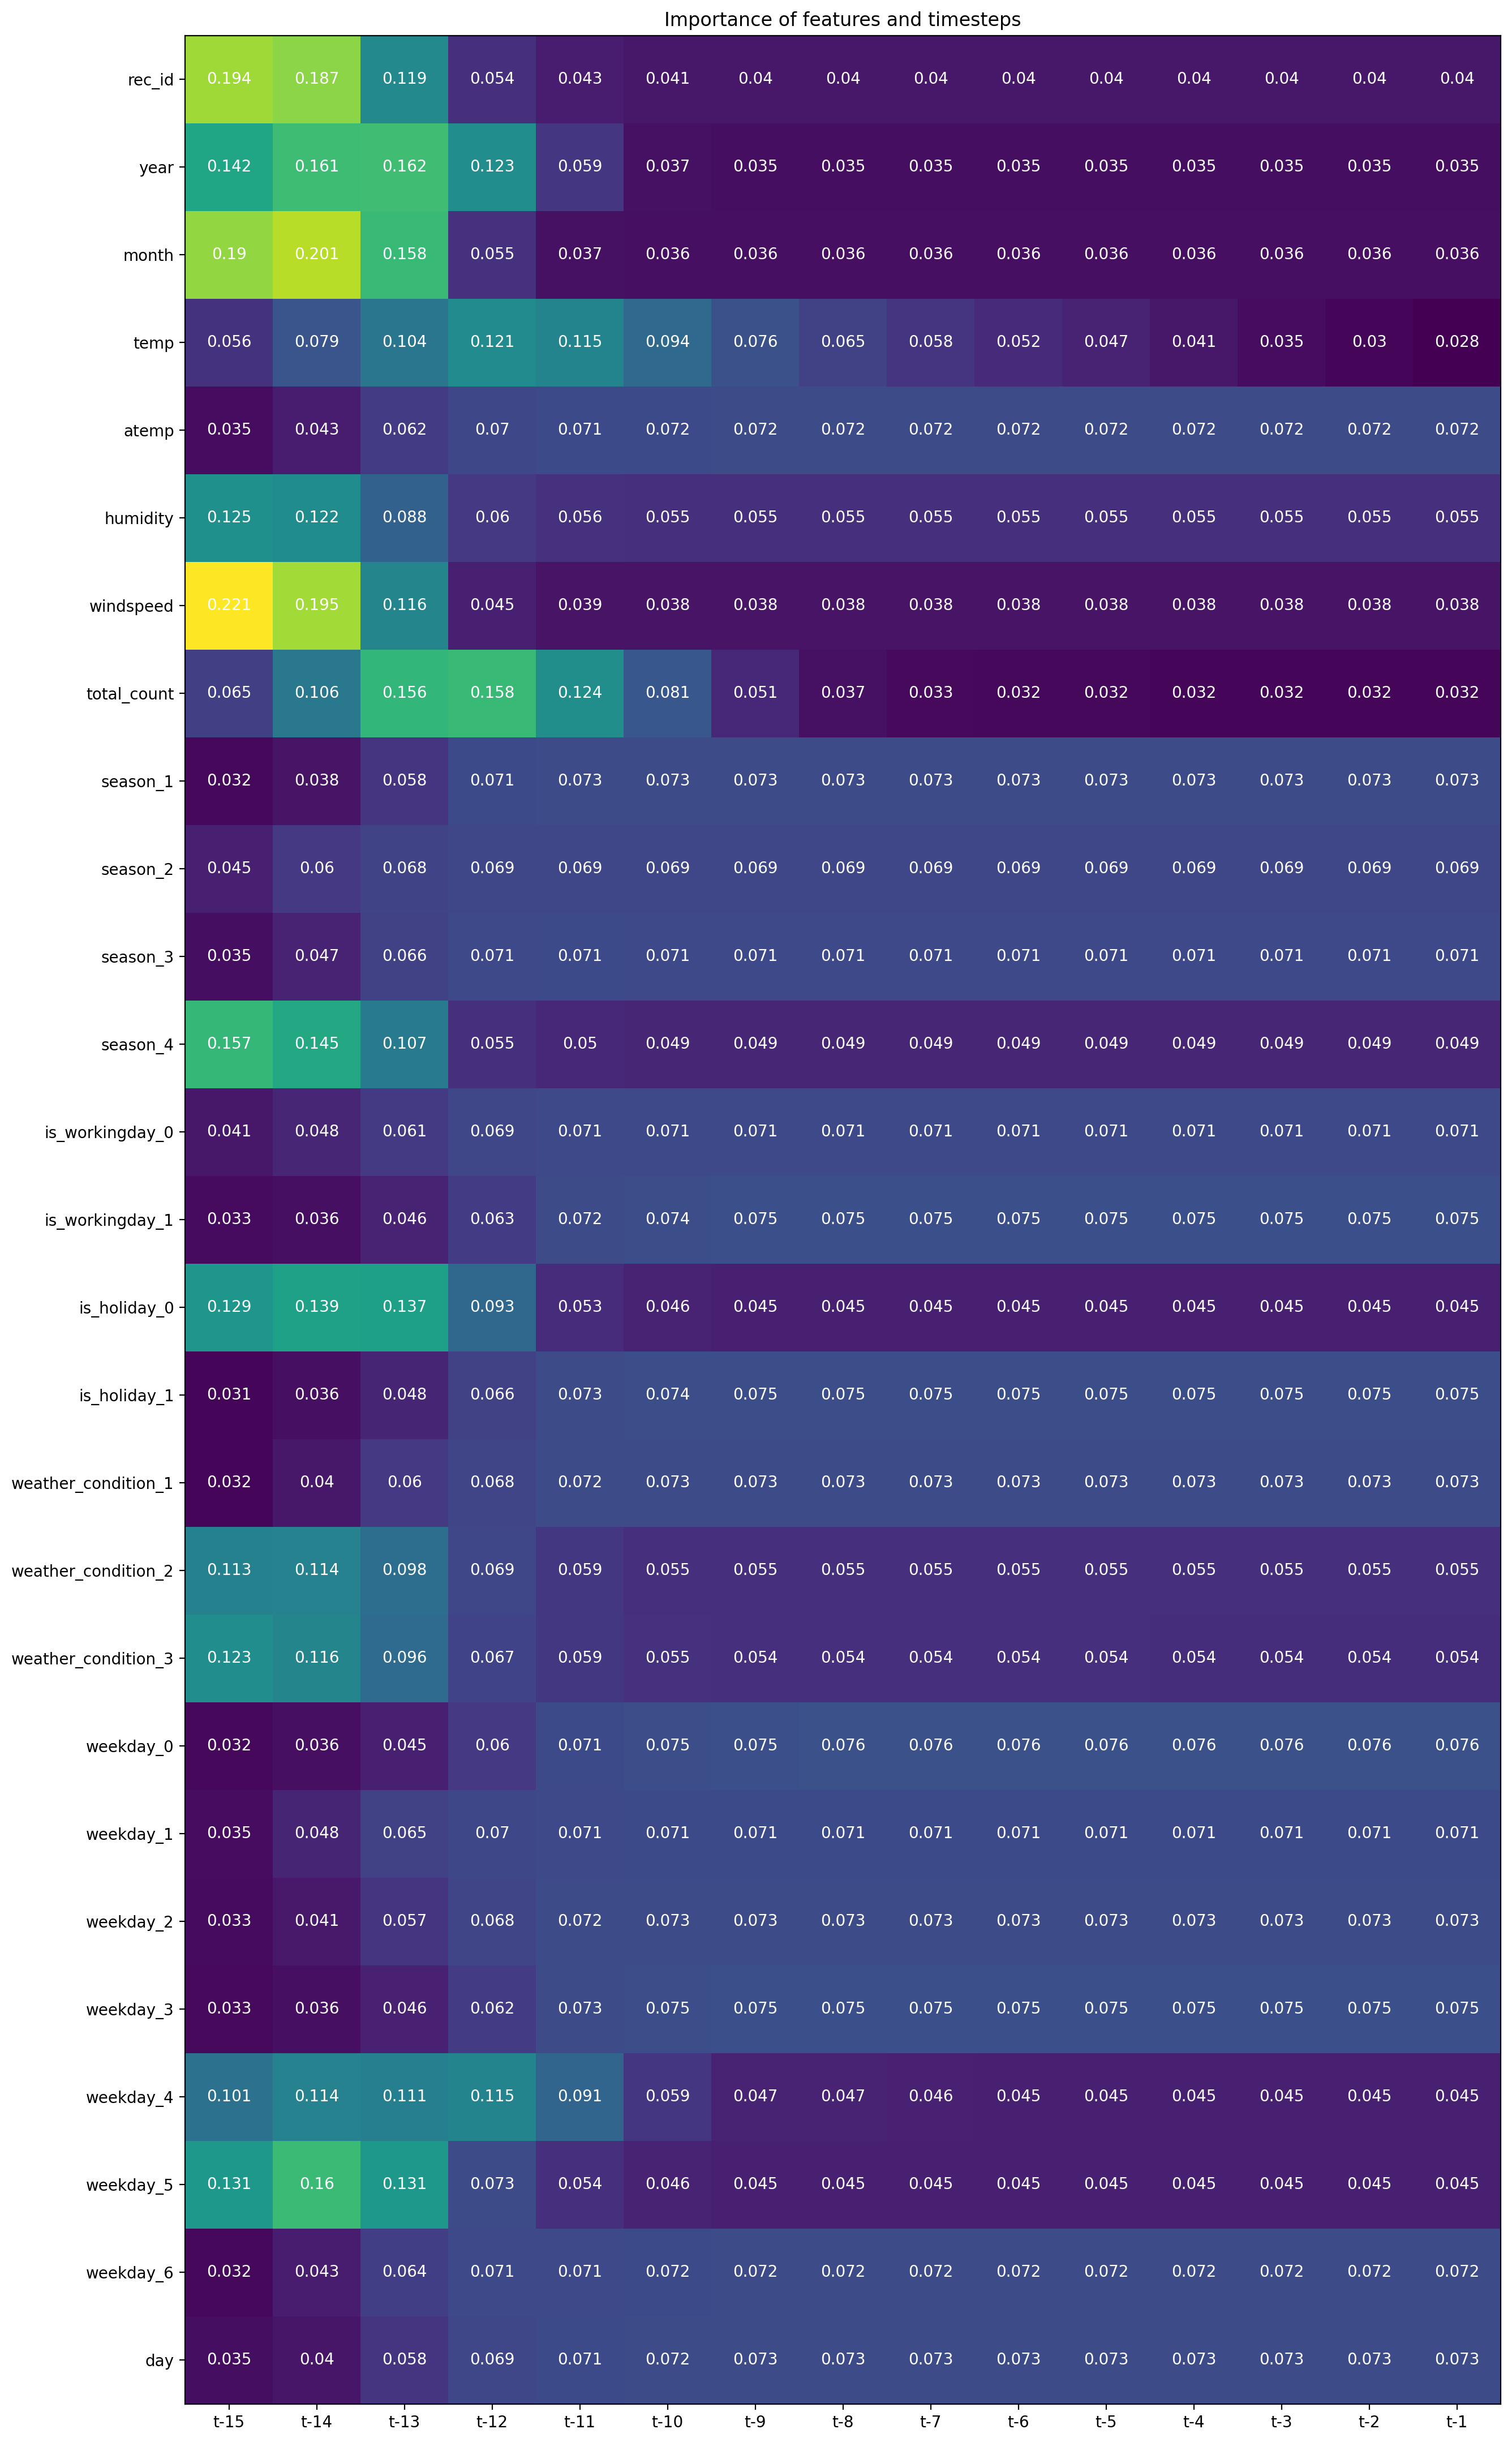

In [26]:
print(X_train[1].shape)
X_train_t = torch.Tensor(X_train)

fig, ax = plt.subplots(figsize=(15, 30))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

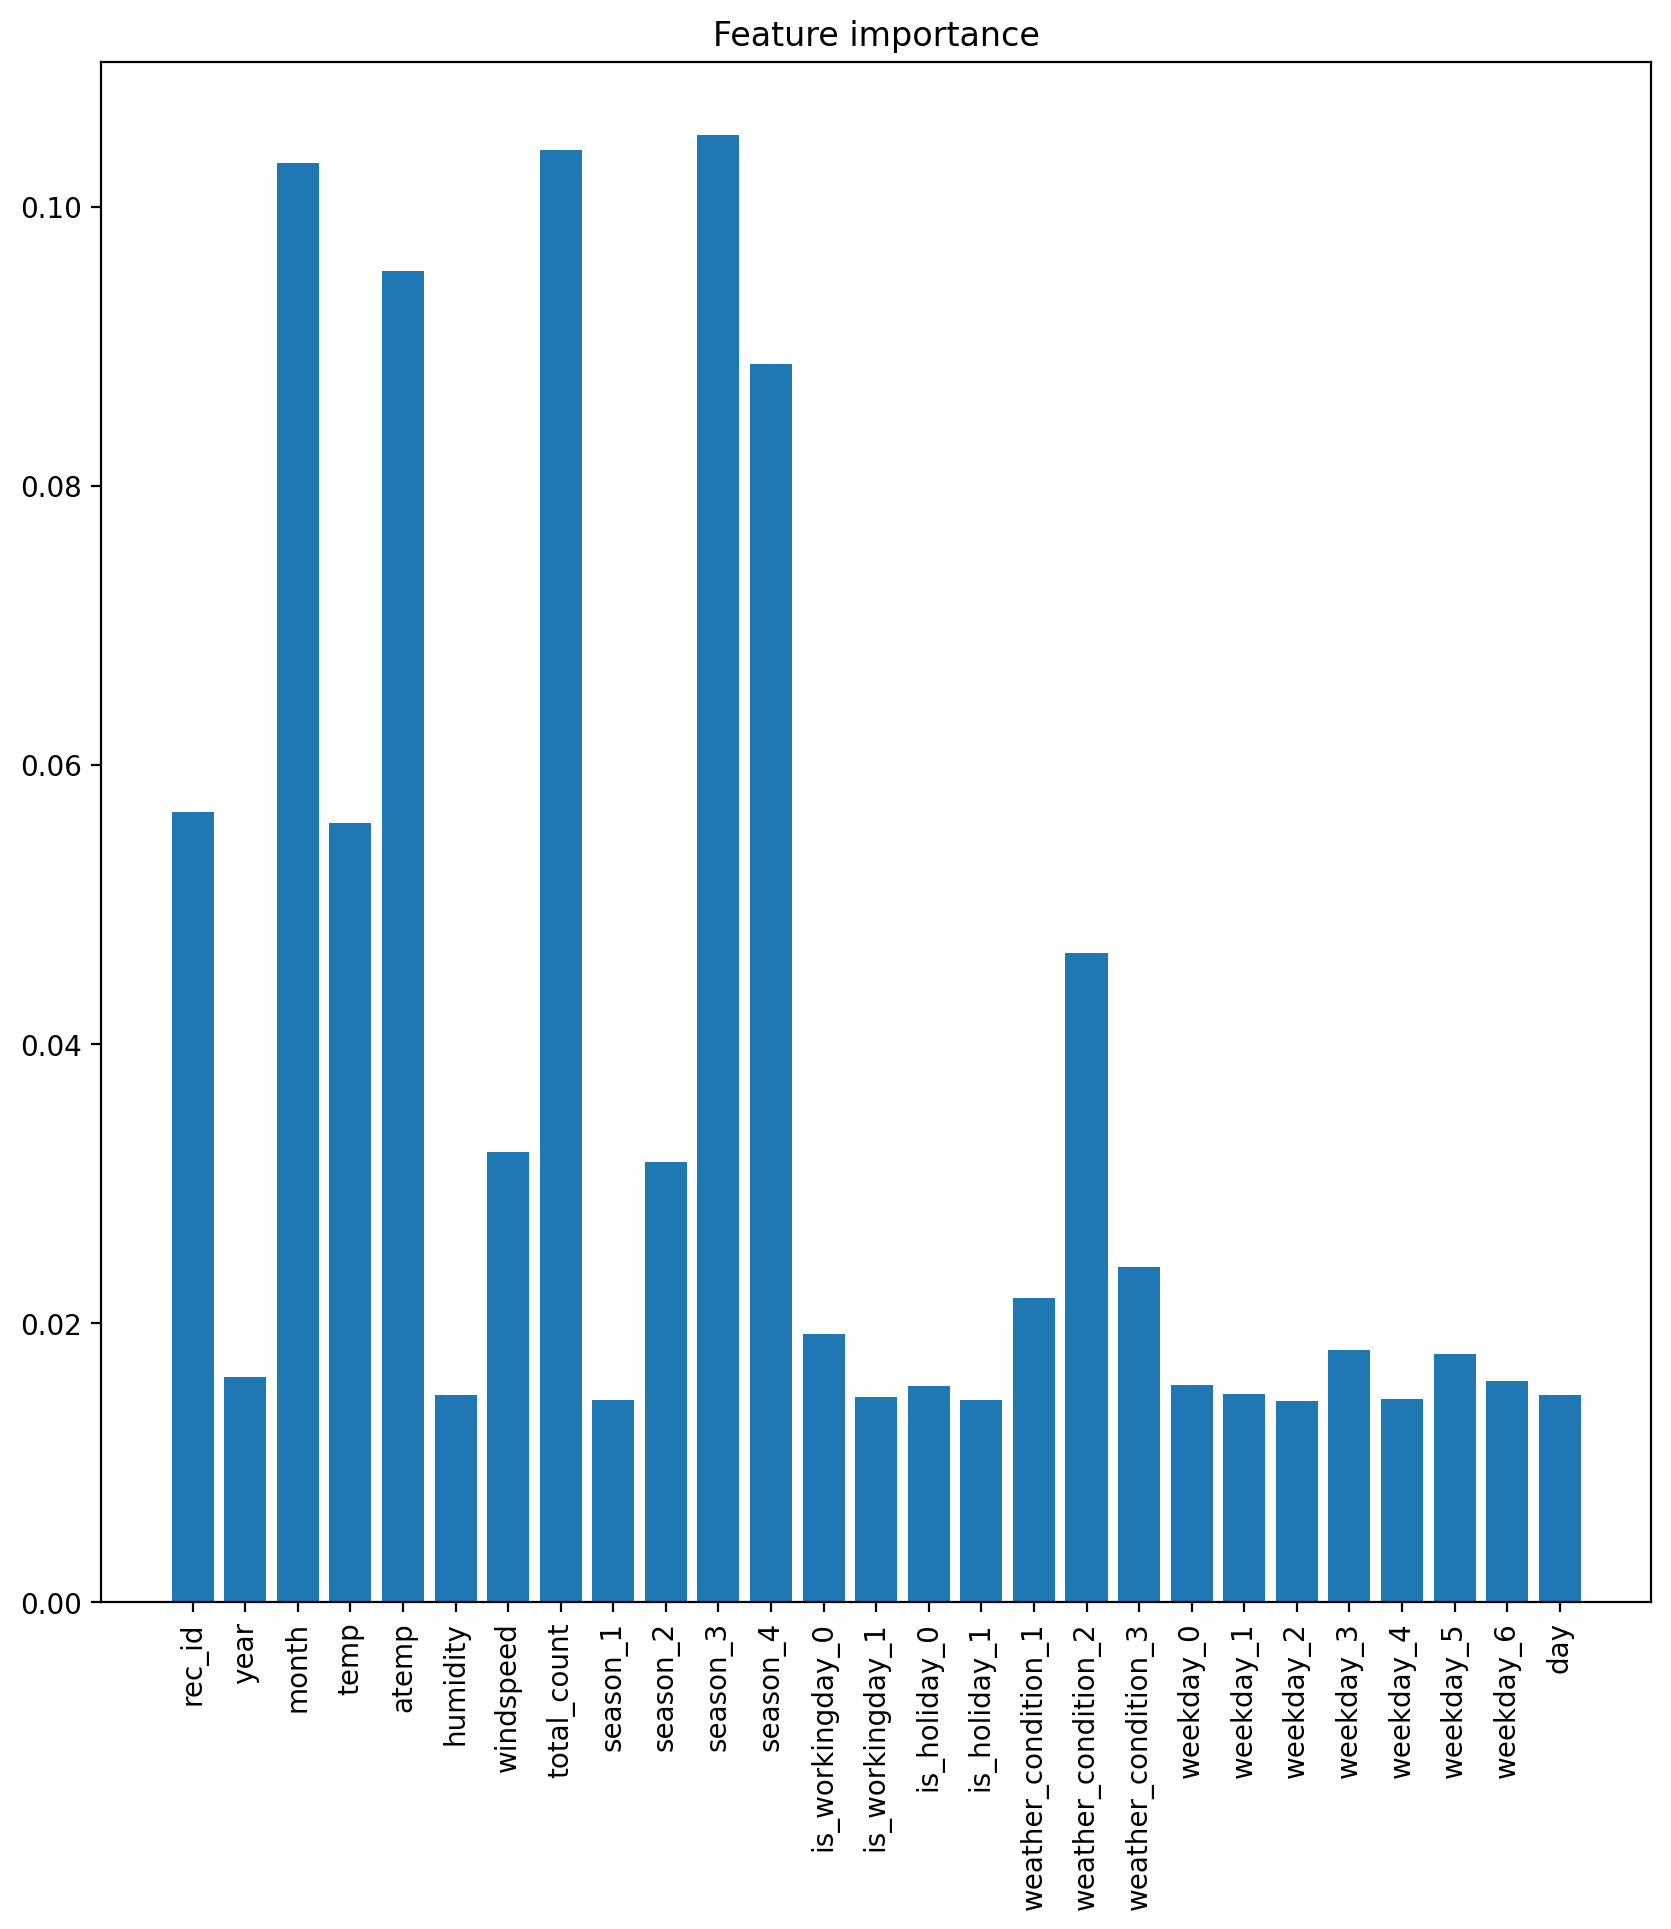

In [27]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(range(len(cols)), cols, rotation=90);